In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [5]:
ls

gdrive/  sample_data/




---


Change Dir to Shared Drive that Contains RADAR Heatmap Images

In [6]:
import os
os.chdir("/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/Data/")

In [7]:
ls

IMU_Streams/  Radar_Data/                  SensorConfig.docx
plot.png      Radar_PostProcess_Heatmaps/




---
Install PyTorch and Ensure GPU is Working


In [ ]:
!pip3 install torch torchvision

In [8]:
import glob
import cv2
import os
import os.path as osp
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets

torch.cuda.empty_cache()

In [9]:
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


In [11]:
torch.cuda.is_available()

True



---


Radar Heatmaps Custom Dataset

In [23]:
class_map = {
    'bicyclerack': 0,
    'bush': 1,
    'firehydrant': 2,
    'human': 3,
    'lamppost': 4,
    'middle_of_sidewalk': 5,
    'tree': 6,
    'wall': 7
}


class CustomDataset(Dataset):

    def __init__(self, data_path= 'Radar_PostProcess_Heatmaps/train', transform=None, target_transform=None):
        self.imgs_path = data_path
        file_list = glob.glob(self.imgs_path + '/*')
        #print('file list', file_list)
        if 'test' in self.imgs_path: #to split test data in val and test
            self.ind_threshold = 0.5
        else:
            self.ind_threshold = 1

        self.data = []
        for class_path in file_list:
            class_name = class_path.split('/')[-1]
            # a class can have multiple scenarios (wall class -> glass wall, brick wall)
            for scenario_dir in glob.glob(class_path + '/' + '*'):
                scenario_dir_heatmaps_regex = 'allobjects_1m_*_noaxis.png'
                for img_path in glob.glob(scenario_dir + '/' + scenario_dir_heatmaps_regex):
                    indicator = torch.rand(1)
                    if indicator <= self.ind_threshold:
                        self.data.append([img_path, class_name])
                    else:
                        continue
        #print('data list', self.data)
        
        self.class_map = class_map
        self.img_dim = (400, 200)
        self.transform = transform
        self.target_transform = target_transform
    
    
    def __len__(self):
        return len(self.data)

    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        target = self.class_map[class_name]
        #img_tensor = torch.from_numpy(img)
        #img_tensor = img_tensor.permute(2, 0, 1)
        # target = torch.tensor([target])
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    
    def is_val_img(self, img_path):
        # To divide heatmaps in same folder into train, val, and test sets
        val_frames = ['_frame12_', '_frame14_', '_frame15_', '_frame21_', 
                      '_frame24_', '_frame31_', '_frame35_', '_frame44_',
                      '_frame50_', '_frame54_', '_frame57_', '_frame60_', 
                      '_frame62_', '_frame73_', '_frame85_']
        for frame_num in val_frames:
            if frame_num in img_path:
              return True
        return False

    def is_test_img(self, img_path):
        # To divide heatmaps in same folder into train, val, and test sets
        test_frames = ['_frame4_', '_frame29_', '_frame55_', '_frame90_', '_frame93_']
        for frame_num in test_frames:
            if frame_num in img_path:
              return True
        return False



---


Custom Dataloader

In [24]:
train_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/train', transform=None)		

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
print(f'Train Set Size: {len(train_set)}')
print(f'Train Dataloader Size: {len(train_dataloader)}')

val_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/test', transform=None)		
val_dataloader = DataLoader(val_set, batch_size=5, shuffle=True, num_workers=2)
print(f'Val Set Size: {len(val_set)}')
print(f'Val Dataloader Size: {len(val_dataloader)}')

test_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/test', transform=None)		
test_dataloader = DataLoader(test_set, batch_size=5, shuffle=True, num_workers=2)
print(f'Test Set Size: {len(test_set)}')
print(f'Test Dataloader Size: {len(test_dataloader)}')

Train Set Size: 2100
Train Dataloader Size: 66
Val Set Size: 521
Val Dataloader Size: 105
Test Set Size: 527
Test Dataloader Size: 106


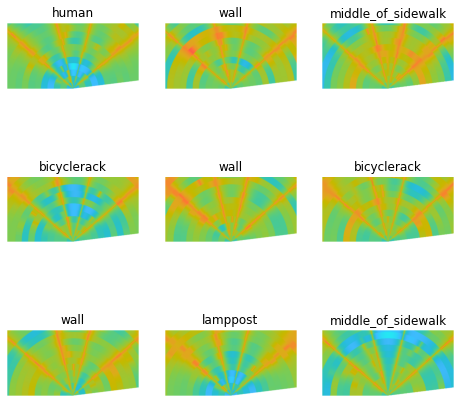

In [25]:
labels_map = dict((v,k) for k,v in class_map.items())

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

Feature batch shape: torch.Size([32, 200, 400, 3])
Labels batch shape: torch.Size([32])


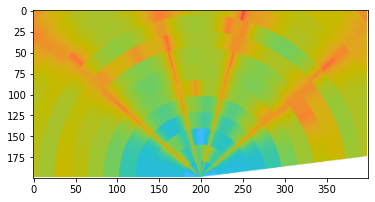

Label: 6
Class: tree


In [26]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")
print(f"Class: {labels_map[label.item()]}")

In [33]:
# Helper Functions to be Used Later

def compute_model_throughput(model, test_dataloader, batch_size):
  # Ref: https://deci.ai/resources/blog/measure-inference-time-deep-neural-networks/
  repetitions=50
  total_time = 0
  all_batch_throughputs = np.zeros(len(test_dataloader))

  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_dataloader):
      for rep in range(repetitions):
        images = images.cuda()  # move to GPU
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        starter.record()
        _ = model(images)
        ender.record()
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender) / 1000
        total_time += curr_time
      batch_throughput = (repetitions*batch_size) / total_time
      all_batch_throughputs[batch_idx] = batch_throughput

  return np.mean(all_batch_throughputs)  # samples / second


def compute_model_inference_time(model, test_dataloader, batch_size):
  # Ref: https://deci.ai/resources/blog/measure-inference-time-deep-neural-networks/
  # INIT LOGGERS
  starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
  repetitions = 50
  timings=np.zeros((repetitions,1))
  all_batch_times = np.zeros(len(test_dataloader))

  for batch_idx, (images, labels) in enumerate(test_dataloader):
    images = images.cuda()
    #GPU-WARM-UP
    for _ in range(10):
      _ = model(images)
    # MEASURE PERFORMANCE
    with torch.no_grad():
      for rep in range(repetitions):
        starter.record()
        _ = model(images)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time
    mean_syn = np.sum(timings) / repetitions
    all_batch_times[batch_idx] = mean_syn

  return np.mean(all_batch_times)  # in milliseconds



---


#Training from Scratch with Custom CNN Model (Baseline)

In [ ]:
EPOCHS = 15
IS_GPU = True
TRAIN_BS = 32
VAL_BS = 5
TEST_BS = 5
TOTAL_CLASSES = 8

train_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize([0,0,0], [1,1,1]), 
     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
     transforms.RandomHorizontalFlip()])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0,0,0], [1,1,1])
     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
     ])

train_set = CustomDataset(fold='train', transform=train_transform)		
train_dataloader = DataLoader(train_set, batch_size=TRAIN_BS, shuffle=True, num_workers=2)
print(f'Train Set Size: {len(train_set)}')
print(f'Train Dataloader Size: {len(train_dataloader)}')

val_set = CustomDataset(fold='val', transform=val_transform)		
val_dataloader = DataLoader(val_set, batch_size=VAL_BS, shuffle=True, num_workers=2)
print(f'Val Set Size: {len(val_set)}')
print(f'Val Dataloader Size: {len(val_dataloader)}')

test_set = CustomDataset(fold='test', transform=val_transform)		
test_dataloader = DataLoader(test_set, batch_size=TEST_BS, shuffle=True, num_workers=2)
print(f'Test Set Size: {len(test_set)}')
print(f'Test Dataloader Size: {len(test_dataloader)}')

Train Set Size: 2480
Train Dataloader Size: 78
Val Set Size: 465
Val Dataloader Size: 93
Test Set Size: 155
Test Dataloader Size: 31


In [ ]:
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

import torch.nn as nn
import torch.nn.functional as F

class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        
        # <<TODO#3>> Add more conv layers with increasing 
        # output channels
        # <<TODO#4>> Add normalization layers after conv
        # layers (nn.BatchNorm2d)

        # Also experiment with kernel size in conv2d layers (say 3
        # inspired from VGGNet)
        # To keep it simple, keep the same kernel size
        # (right now set to 5) in all conv layers.
        # Do not have a maxpool layer after every conv layer in your
        # deeper network as it leads to too much loss of information.

        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 6, 3)

        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)

        # self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # self.norm1 = nn.BatchNorm2d(16)

        # self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # self.norm2 = nn.BatchNorm2d(32)

        # self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # self.norm3 = nn.BatchNorm2d(64)

        # self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # self.norm4 = nn.BatchNorm2d(128)

        # self.pool = nn.MaxPool2d(2, 2)

        # <<TODO#3>> Add more linear (fc) layers
        # <<TODO#4>> Add normalization layers after linear and
        # experiment inserting them before or after ReLU (nn.BatchNorm1d)
        # More on nn.sequential:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Sequential
        
        self.fc_net = nn.Sequential(
            nn.Linear(114654, TOTAL_CLASSES//2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(TOTAL_CLASSES//2),
            nn.Linear(TOTAL_CLASSES//2, TOTAL_CLASSES),
        )

        # self.fc_net = nn.Sequential(
        #     nn.Linear(256 * 8 * 8, 2048),
        #     nn.ReLU(inplace=True),
        #     nn.BatchNorm1d(2048),
        #     nn.Linear(2048, 512),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(512, TOTAL_CLASSES),
        # )

    def forward(self, x):

        # <<TODO#3&#4>> Based on the above edits, you'll have
        # to edit the forward pass description here.

        # x = self.pool(F.relu(self.conv1(x)))
        # Output size = 28//2 x 28//2 = 14 x 14

        # x = self.pool(F.relu(self.conv2(x)))
        # Output size = 10//2 x 10//2 = 5 x 5

        x = self.norm1(F.relu(self.conv1(x)))
        x = self.norm2(F.relu(self.conv2(x)))
        x = self.pool(self.norm1(F.relu(self.conv3(x))))

        # See the CS231 link to understand why this is 16*5*5!
        # This will help you design your own deeper network
        x = x.view(x.size(0), 114654)
        x = self.fc_net(x)

        # x = F.relu(self.norm1(self.conv1(x)))
        # x = F.relu(self.norm2(self.conv2(x)))
        # x = self.pool(F.relu(self.norm3(self.conv3(x))))
        # x = self.pool(F.relu(self.norm4(self.conv4(x))))

        # x = x.view(x.size(0), 640000)
        # x = self.fc_net(x)

        # No softmax is needed as the loss function in step 3
        # takes care of that
        
        return x

# Create an instance of the nn.module class defined above:
net = BaseNet()

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()
    model_total_params = sum(p.numel() for p in net.parameters())
    print(f'Total Params: {model_total_params}')


Total Params: 460630


In [ ]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum is useful or not
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []


<Figure size 432x288 with 0 Axes>

In [ ]:
def calculate_val_accuracy(valloader, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        valloader (torch.utils.data.DataLoader): val set 
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """    
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    for data in valloader:
        images, labels = data
        if is_gpu:
            images = images.cuda()
            labels = labels.cuda()
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(list(predicted.cpu().numpy()))
        total += labels.size(0)
        correct += (predicted == labels).sum()

        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy

In [ ]:
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize. We evaluate the validation accuracy at each
# epoch and plot these values over the number of epochs
# Nothing to change here
# -----------------------------
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0.
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs
        inputs, labels = data

        if IS_GPU:
            inputs = inputs.cuda()
            labels = labels.cuda()

        total += labels.size(0)

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    # Normalizing the loss by the total number of train batches
    running_loss/=len(train_dataloader)
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_val_accuracy(val_dataloader, IS_GPU)
    print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    # Optionally print classwise accuracies
    for c_i in range(TOTAL_CLASSES):
        print('Accuracy of %5s : %2d %%' % (
            labels_map[c_i], val_classwise_accuracy[c_i]))

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy)
# -----------------------------


# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("plot.png")
plt.close(fig)
print('Finished Training')

print('Saving Model')
model_name = 'basenet'
torch.save(net.state_dict(), f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth')
print('Model Saved')

# Load saved model and run throughput and inference tests of model on test set
saved_model = BaseNet()
saved_model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth'))
saved_model = saved_model.cuda()
saved_model.eval()

tp = compute_model_throughput(saved_model, test_dataloader, TEST_BS)
print(f'Avg Throughput of Model on Test Images: {tp} images/s')
time = compute_model_inference_time(saved_model, test_dataloader, TEST_BS)
print(f'Avg Inference Time of Model on Test Images: {time} ms')
# -------------

#Transfer Learning with Pretrained Models

In [29]:
models_map = {
    'resnet': 'resnet18',
    'vgg': 'vgg11',
    'squeezenet': 'squeezenet1_0',
    'mobilenet': 'mobilenetv2'
    }

class PreTrainedResNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedResNet, self).__init__()
    
    #TODO1: Load pre-trained ResNet Model
    self.resnet18 = models.resnet18(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.resnet18.parameters():
          param.requires_grad = False
    
    #Replace last fc layer
    num_feats = self.resnet18.fc.in_features
    
    #TODO2: Replace fc layer in resnet to a linear layer of size (num_feats, num_classes)
    self.resnet18.fc = nn.Linear(num_feats, num_classes)
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.resnet18(x)

    return x


class PreTrainedVGGNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedVGGNet, self).__init__()
    
    #TODO1: Load pre-trained VGGNet Model
    self.vgg11 = models.vgg11(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.vgg11.parameters():
          param.requires_grad = False
    
    #Replace output layer (Ref: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
    self.vgg11.classifier[6] = nn.Linear(4096, num_classes)
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.vgg11(x)

    return x


class PreTrainedSqueezeNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedSqueezeNet, self).__init__()
    
    #TODO1: Load pre-trained SqueezeNet Model
    self.squeezenet1_0 = models.squeezenet1_0(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.squeezenet1_0.parameters():
          param.requires_grad = False
    
    #TODO2: Replace output layer (Ref: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
    self.squeezenet1_0.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    self.squeezenet1_0.num_classes = num_classes
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.squeezenet1_0(x)

    return x


class PreTrainedMobileNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedMobileNet, self).__init__()
    
    #TODO1: Load pre-trained MobileNet Model
    self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.mobilenet_v2.parameters():
          param.requires_grad = False
    
    #TODO2: Replace output layer (Ref: https://stackoverflow.com/questions/57285224/fine-tuning-pretrained-model-mobilenet-v2-in-pytorch)
    self.mobilenet_v2.classifier[1] = nn.Linear(self.mobilenet_v2.last_channel, num_classes)
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.mobilenet_v2(x)

    return x


In [32]:
# Nothing to be edited in this cell
def calculate_val_accuracy(valloader, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        valloader (torch.utils.data.DataLoader): val set 
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """    
    model.eval()
  
    correct = 0.0
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))
  
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(valloader):
          #move to GPU
          images, labels = images.cuda(), labels.cuda()
          total += labels.size(0)

          #forward
          outputs = model.forward(images)

          _, preds = torch.max(outputs.data, 1)
          predictions.extend(list(preds.cpu().numpy()))

          correct += (preds == labels).sum()

          c = (preds == labels).squeeze()
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i]
              class_total[label] += 1

        
    class_accuracy = np.divide(class_correct, class_total)
    validation_acc = correct/total

    return validation_acc, class_accuracy


In [31]:
def train(model, optimizer, criterion, epoch, num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_acc = 0.0
  total = 0.
  
  for batch_idx, (images, labels) in enumerate(train_dataloader):
    #zero the parameter gradients
    optimizer.zero_grad()
    
    #move to GPU
    images, labels = images.cuda(), labels.cuda()
    total += labels.size(0)
    
    #forward
    outputs = model.forward(images)
    
    loss = criterion(outputs, labels)
    
    _, preds = torch.max(outputs.data, 1)
    
    loss.backward()
    optimizer.step()
    
    epoch_loss += loss.item()
    epoch_acc += torch.sum(preds == labels).item()
    
  epoch_loss /= len(train_dataloader)
  epoch_acc /= total

  # Calculate validation set accuracy of the existing model
  val_accuracy, val_classwise_accuracy = \
      calculate_val_accuracy(val_dataloader, IS_GPU)
  
  print(f'Epoch {epoch}/{num_epochs} Training Loss {epoch_loss} Training Accuracy {100*epoch_acc}% Validation Accuracy {100*val_accuracy}%')

  # Optionally print classwise accuracies
  for c_i in range(TOTAL_CLASSES):
    print(f'Accuracy of {labels_map[c_i]} : {100*val_classwise_accuracy[c_i]}%')
  

In [38]:
#TODO: Vary Hyperparams

IS_GPU = True
NUM_EPOCHS = 15
LEARNING_RATE = 0.001
TRAIN_BS = 32
VAL_BS = 5
TEST_BS = 5
TOTAL_CLASSES = 8

train_transform = transforms.Compose(
    [transforms.ToTensor(), 
     #transforms.Normalize([0,0,0], [1,1,1]), 
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
     transforms.RandomHorizontalFlip()])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize([0,0,0], [1,1,1])
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
     ])

train_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/train', transform=train_transform)		

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
print(f'Train Set Size: {len(train_set)}')
print(f'Train Dataloader Size: {len(train_dataloader)}')

val_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/test', transform=val_transform)		
val_dataloader = DataLoader(val_set, batch_size=5, shuffle=True, num_workers=2)
print(f'Val Set Size: {len(val_set)}')
print(f'Val Dataloader Size: {len(val_dataloader)}')

test_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/test', transform=val_transform)		
test_dataloader = DataLoader(test_set, batch_size=5, shuffle=True, num_workers=2)
print(f'Test Set Size: {len(test_set)}')
print(f'Test Dataloader Size: {len(test_dataloader)}')



Train Set Size: 2100
Train Dataloader Size: 66
Val Set Size: 533
Val Dataloader Size: 107
Test Set Size: 507
Test Dataloader Size: 102


In [39]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

#print('sample shape', img)


Feature batch shape: torch.Size([32, 3, 200, 400])
Labels batch shape: torch.Size([32])


##ResNet18

In [ ]:
RESNET_LAST_ONLY = False #Fine tunes only the last layer. Set to False to fine tune entire network

#Initialize the model
model = PreTrainedResNet(TOTAL_CLASSES, RESNET_LAST_ONLY)
model = model.cuda()
model_total_params = sum(p.numel() for p in model.parameters())
print(f'Total Params: {model_total_params}')

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  
print("Finished Training")
print("-"*10)

print('Saving Model')
model_name = models_map['resnet']
torch.save(model.state_dict(), f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth')
print('Model Saved')

# Load saved model and run throughput and inference tests of model on test set
saved_model = PreTrainedResNet(TOTAL_CLASSES, RESNET_LAST_ONLY)
saved_model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth'))
saved_model = saved_model.cuda()
saved_model.eval()

tp = compute_model_throughput(saved_model, test_dataloader, TEST_BS)
print(f'Avg Throughput of Model on Test Images: {tp} images/s')
time = compute_model_inference_time(saved_model, test_dataloader, TEST_BS)
print(f'Avg Inference Time of Model on Test Images: {time} ms')

##VGGNet

In [ ]:
VGGNET_LAST_ONLY = False

#Initialize the model
model = PreTrainedVGGNet(TOTAL_CLASSES, VGGNET_LAST_ONLY)
model = model.cuda()
model_total_params = sum(p.numel() for p in model.parameters())
print(f'Total Params: {model_total_params}')

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  
print("Finished Training")
print("-"*10)

print('Saving Model')
model_name = models_map['vgg']
torch.save(model.state_dict(), f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth')
print('Model Saved')

# Load saved model and run throughput and inference tests of model on test set
saved_model = PreTrainedVGGNet(TOTAL_CLASSES, VGGNET_LAST_ONLY)
saved_model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth'))
saved_model = saved_model.cuda()
saved_model.eval()

tp = compute_model_throughput(saved_model, test_dataloader, TEST_BS)
print(f'Avg Throughput of Model on Test Images: {tp} images/s')
time = compute_model_inference_time(saved_model, test_dataloader, TEST_BS)
print(f'Avg Inference Time of Model on Test Images: {time} ms')

##SqueezeNet 1.0

In [ ]:
SQUEEZENET_LAST_ONLY = False

#Initialize the model
model = PreTrainedSqueezeNet(TOTAL_CLASSES, SQUEEZENET_LAST_ONLY)
model = model.cuda()
model_total_params = sum(p.numel() for p in model.parameters())
print(f'Total Params: {model_total_params}')

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  
print("Finished Training")
print("-"*10)

print('Saving Model')
model_name = models_map['squeezenet']
torch.save(model.state_dict(), f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth')
print('Model Saved')

# Load saved model and run throughput and inference tests of model on test set
saved_model = PreTrainedSqueezeNet(TOTAL_CLASSES, SQUEEZENET_LAST_ONLY)
saved_model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth'))
saved_model = saved_model.cuda()
saved_model.eval()

tp = compute_model_throughput(saved_model, test_dataloader, TEST_BS)
print(f'Avg Throughput of Model on Test Images: {tp} images/s')
time = compute_model_inference_time(saved_model, test_dataloader, TEST_BS)
print(f'Avg Inference Time of Model on Test Images: {time} ms')

##MobileNetv2

In [40]:
MOBILENET_LAST_ONLY = False

#Initialize the model
model = PreTrainedMobileNet(TOTAL_CLASSES, MOBILENET_LAST_ONLY)
model = model.cuda()
model_total_params = sum(p.numel() for p in model.parameters())
print(f'Total Params: {model_total_params}')

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  
print("Finished Training")
print("-"*10)

print('Saving Model')
model_name = models_map['mobilenet']
torch.save(model.state_dict(), f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth')
print('Model Saved')

# Load saved model and run throughput and inference tests of model on test set
saved_model = PreTrainedMobileNet(TOTAL_CLASSES, MOBILENET_LAST_ONLY)
saved_model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth'))
saved_model = saved_model.cuda()
saved_model.eval()

tp = compute_model_throughput(saved_model, test_dataloader, TEST_BS)
print(f'Avg Throughput of Model on Test Images: {tp} images/s')
time = compute_model_inference_time(saved_model, test_dataloader, TEST_BS)
print(f'Avg Inference Time of Model on Test Images: {time} ms')

Total Params: 2234120
Epoch 1/15 Training Loss 1.4358980908538357 Training Accuracy 48.952380952380956% Validation Accuracy 29.643526077270508%
Accuracy of bicyclerack : 0.0%
Accuracy of bush : 19.148935317993164%
Accuracy of firehydrant : 0.8849557638168335%
Accuracy of human : 0.0%
Accuracy of lamppost : 77.96610260009766%
Accuracy of middle_of_sidewalk : 39.130435943603516%
Accuracy of tree : 7.272727012634277%
Accuracy of wall : 79.20792388916016%
Epoch 2/15 Training Loss 0.7678759928905603 Training Accuracy 75.38095238095238% Validation Accuracy 30.956850051879883%
Accuracy of bicyclerack : 12.280701637268066%
Accuracy of bush : 23.404254913330078%
Accuracy of firehydrant : 26.54867172241211%
Accuracy of human : 5.454545497894287%
Accuracy of lamppost : 52.5423698425293%
Accuracy of middle_of_sidewalk : 15.217391967773438%
Accuracy of tree : 7.272727012634277%
Accuracy of wall : 71.28712463378906%
Epoch 3/15 Training Loss 0.4946551934787721 Training Accuracy 85.42857142857143% Val

In [41]:
test_accuracy, test_classwise_accuracy = \
      calculate_val_accuracy(test_dataloader, IS_GPU)

print(f'test accuracy: {100*test_accuracy}')

for c_i in range(TOTAL_CLASSES):
  print(f'Accuracy of {labels_map[c_i]} : {100*test_classwise_accuracy[c_i]}%')



test accuracy: 40.03944778442383
Accuracy of bicyclerack : 24.528303146362305%
Accuracy of bush : 43.13725662231445%
Accuracy of firehydrant : 46.93877410888672%
Accuracy of human : 43.47826385498047%
Accuracy of lamppost : 12.244897842407227%
Accuracy of middle_of_sidewalk : 0.0%
Accuracy of tree : 11.111111640930176%
Accuracy of wall : 87.3786392211914%


##Visualize Predicted vs Actual for Some Test Heatmaps

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated
    
def visualize_model(model, class_names, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for batch_idx, (images, labels) in enumerate(test_dataloader):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()
        
        outputs = model(images)
        
        _, preds = torch.max(outputs.data, 1)
       

        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))

            imshow(images.cpu().data[j])

            if images_so_far == num_images:
                return

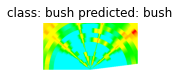

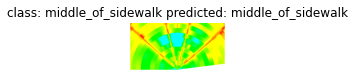

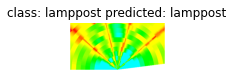

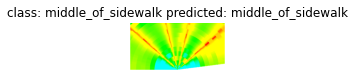

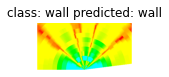

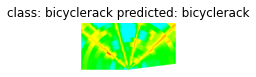

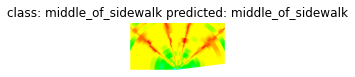

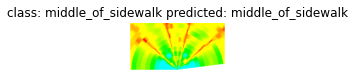

In [ ]:
class_names = list(class_map.keys())
visualize_model(model, class_names, 8)